In [0]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.utils.data as Data
import torchvision
import pickle

from torch.autograd import Variable
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score

%matplotlib inline
np.random.seed(0)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
torch.set_default_tensor_type('torch.DoubleTensor')

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
os.chdir('/content/drive/My Drive/DL Assignment')

In [0]:
Data = pd.read_csv('./Data_2/data.csv',delimiter = ',',header = None)
labels = pd.read_csv('./Data_2/label.csv',delimiter = ',',header = None)

X = np.array(Data.iloc[:, 0:784])
Y = np.array(Data.iloc[:, 784])

#train,test splt
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state=0)

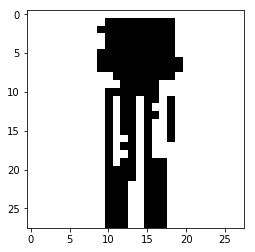

In [5]:
plt.imshow(X[401].reshape(28,28),cmap = 'gray')

In [0]:
#### Auto Encoder  #############

def Flip_Bits(data, percentage):
  noisy_data = data.copy()
  for i in range(data.shape[0]):
    select_pixels = np.random.randint(0,data.shape[1], (int(percentage*data.shape[1])))
    noisy_data[i,select_pixels] = 1 - data[i,select_pixels]
    
  return noisy_data

class ConcatDataset(torch.utils.data.Dataset):
    def __init__(self, *datasets):
        self.datasets = datasets

    def __getitem__(self, i):
        return tuple(d[i] for d in self.datasets)

    def __len__(self):
        return min(len(d) for d in self.datasets)

class AutoEncoder(nn.Module):
    def __init__(self,D_in, NL, L):
        super(AutoEncoder, self).__init__()

        self.encoder = nn.Sequential(
            nn.Linear(D_in, NL),
            nn.ReLU(),
            nn.Linear(NL, L),
        )
        self.decoder = nn.Sequential(
            nn.Linear(L, NL),
            nn.ReLU(),
            nn.Linear(NL, D_in),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = x.double()
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return encoded, decoded
    
      
def First_AE_Model(x_train, x_train_noisy, bottle_neck_size,nonlinear_layer_size):
  
  '''device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
  torch.set_default_tensor_type('torch.DoubleTensor')
  dtype = torch.int64'''
  
      
  x_train_torch = torch.tensor(x_train); 
  x_train_torch = x_train_torch.to(device)
  
  '''x_test_torch = torch.tensor(x_test); 
  x_test_torch = x_test_torch.to(device)'''
  
  x_train_noisy_torch = torch.tensor(x_train_noisy); 
  x_train_noisy_torch = x_train_noisy_torch.to(device)
  
  '''x_test_noisy_torch = torch.tensor(x_test_noisy); 
  x_test_noisy_torch = x_test_noisy_torch.to(device)'''


  D_in = 784
  NL = nonlinear_layer_size
  L = bottle_neck_size
  MAX_EPOCH = 1000
  BATCH_SIZE = 2048
  LR = 1e-4        


  train_loader = torch.utils.data.DataLoader(ConcatDataset(x_train_torch,x_train_noisy_torch), batch_size=BATCH_SIZE, shuffle=False)


  AE = AutoEncoder(D_in, NL, L)
  AE = AE.to(device)
  optimizer = torch.optim.Adam(AE.parameters(), lr=LR)
  loss_fn = torch.nn.MSELoss()
  error_train = []
  for epoch in range(MAX_EPOCH):
      batch_loss = []
      for data in train_loader:  
        
        img, img_noisy = data
        
        img_noisy = img_noisy.double()

        encoded, decoded = AE(img_noisy)
        
        decoded = decoded.double()
        img = img.double()

        loss = loss_fn(decoded, img)

        batch_loss.append(loss.item())
        optimizer.zero_grad()               
        loss.backward()                     
        optimizer.step()  

      mean_batch_loss = np.mean(batch_loss)
      del batch_loss
      if epoch % 50 == 0:
          print(epoch, mean_batch_loss.item())    
      error_train.append(mean_batch_loss.item())

      if  epoch>= 5 and abs(error_train[epoch-1] - error_train[epoch]) <= 1e-5:
        print('Reached threshold')
        break     
  plt.plot(error_train, color = 'g', label = 'Reconstruction error')
  plt.legend()

  plt.xlabel('epochs')
  plt.ylabel('MSE loss')
  plt.title('Loss vs epochs')
  plt.show()
  
  print('***********************************')
  print('number of epochs:', len(error_train))
  print('training reconstruction error: ', error_train[-1])
   
  '''x_test_noisy_torch = x_test_noisy_torch.double()
  _ , decoded_test = AE(x_test_noisy_torch)      
  decoded_test = decoded_test.double()
  x_test_torch = x_test_torch.double()
  loss_test = loss_fn(decoded_test, x_test_torch)
  loss_test = loss_test.item()
  print('testing reconstruction error: ', loss_test)
  print('***********************************')'''
  
  x_train_noisy_torch = x_train_noisy_torch.double()
  '''x_test_noisy_torch = x_test_noisy_torch.double()'''
  
  x_train_ae , x_train_denoised = AE(x_train_noisy_torch)
  x_train_ae = x_train_ae.cpu().detach().numpy()###################################
  #x_train_denoised = np.where(x_train_denoised>=0.5,1,0)
  
  '''_ , x_test_denoised = AE(x_test_noisy_torch)
  x_test_denoised = x_test_denoised.cpu().detach().numpy()
  x_test_denoised = np.where(x_test_denoised>=0.5,1,0)'''
  
  
  return AE, x_train_ae

def AutoEncoderModel(x, input_size, hidden_size, bottle_neck_size):
 
  dtype = torch.int64
  
  print("bottle_neck_size : ",bottle_neck_size)
  print('***********************************')
  x_torch = torch.tensor(x); 
  x_torch = x_torch.to(device)
  

  D_in = input_size
  NL = hidden_size
  L = bottle_neck_size
  MAX_EPOCH = 1000
  BATCH_SIZE = 2048
  LR = 1e-4        
  ERROR_THRESHOLD = 1e-4

  train_loader = torch.utils.data.DataLoader(x_torch, batch_size = BATCH_SIZE, shuffle=False)


  AE = AutoEncoder(D_in, NL, L)
  AE = AE.to(device)
  optimizer = torch.optim.Adam(AE.parameters(), lr=LR)
  loss_fn = torch.nn.MSELoss(reduction='mean')
  error_train = []
  for epoch in range(MAX_EPOCH):
      batch_loss = []
      for data in train_loader: 
        
        data = data.double()

        encoded, decoded = AE(data)
        decoded = decoded.double()

        loss = loss_fn(decoded, data)

        batch_loss.append(loss.item())
        optimizer.zero_grad()               
        loss.backward()                     
        optimizer.step()  
       
      mean_batch_loss = np.mean(batch_loss)
      del batch_loss
      if epoch % 100 == 0:
          print(epoch, mean_batch_loss.item())    
      error_train.append(mean_batch_loss.item())

      if  epoch>= 5 and abs(error_train[epoch-4] - error_train[epoch]) <= ERROR_THRESHOLD:
        print('Reached threshold')
        break     
  plt.plot(error_train, color = 'g', label = 'reconstruction error')
  plt.legend()

  plt.xlabel('epochs')
  plt.ylabel('MSE')
  plt.title('MSE vs epochs')
  plt.show()
  
  print('***********************************')
  print('number of epochs:', len(error_train))
  print('reconstruction error: ', error_train[-1])
  print('***********************************')
  print('***********************************')
  
  x_ae, _ = AE(x_torch)
  x_ae = x_ae.cpu().detach()
  
  
  return AE,x_ae

In [0]:
def Stacked_AE_Models(x_train,bottle_neck_size):
  
  D_in = x_train.shape[1]
  
  D_in_1 = D_in
  D_in_2 = bottle_neck_size
  D_in_3 = int((D_in_2)*0.7*0.7)
  
  AE1, feat1 = AutoEncoderModel(x_train, D_in_1, int(D_in_1*0.7), bottle_neck_size)
  AE2, feat2 = AutoEncoderModel(feat1, D_in_2, int(D_in_2*0.7), D_in_3)
  AE3, feat3 = AutoEncoderModel(feat2, D_in_3, int(D_in_3*0.7), int(D_in_3*0.7*0.7))
  
  
  return AE1,AE2,AE3

def Stacked_AEs(bottle_neck_size):
  
  D_in = 784
  
  D_in_1 = D_in
  D_in_2 = bottle_neck_size
  D_in_3 = int((D_in_2)*0.7*0.7)
  
  AE1 = AutoEncoder(D_in_1, int(D_in_1*0.7), bottle_neck_size)
  AE2 = AutoEncoder(D_in_2, int(D_in_2*0.7), D_in_3)
  AE3 = AutoEncoder(D_in_3, int(D_in_3*0.7), int(D_in_3*0.7*0.7))
  
  
  return AE1, AE2, AE3

class ConcatDataset(torch.utils.data.Dataset):
    def __init__(self, *datasets):
        self.datasets = datasets

    def __getitem__(self, i):
        return tuple(d[i] for d in self.datasets)

    def __len__(self):
        return min(len(d) for d in self.datasets)
      
def Stacked_Denoising_AE(x_train,x_train_noisy,x_test,x_test_noisy,bottle_neck_size):
  
  x_train_torch = torch.tensor(x_train); 
  x_train_torch = x_train_torch.to(device)  
  x_test_torch = torch.tensor(x_test); 
  x_test_torch = x_test_torch.to(device)
  
  x_train_noisy_torch = torch.tensor(x_train_noisy); 
  x_train_noisy_torch = x_train_noisy_torch.to(device)
  x_test_noisy_torch = torch.tensor(x_test_noisy); 
  x_test_noisy_torch = x_test_noisy_torch.to(device)
  
  AE1,AE2,AE3 = Stacked_AE_Models(x_train,bottle_neck_size)
  
  Denoiser = torch.nn.Sequential(AE1.encoder,AE2.encoder,AE3.encoder,AE3.decoder,AE2.decoder,AE1.decoder)  
  Denoiser = Denoiser.to(device)
  
  ###################
  train_loader = torch.utils.data.DataLoader(ConcatDataset(x_train_torch,x_train_noisy_torch), batch_size=2048, shuffle=False)
  optimizer = torch.optim.Adam(Denoiser.parameters(), lr=1e-4)
  loss_fn = torch.nn.MSELoss()
  error_train = []
  for epoch in range(1000):
      batch_loss = []
      for data in train_loader:  
        
        img, img_noisy = data
        
        img_noisy = img_noisy.double()

        decoded = Denoiser(img_noisy)
        
        decoded = decoded.double()
        img = img.double()

        loss = loss_fn(decoded, img)

        batch_loss.append(loss.item())
        optimizer.zero_grad()               
        loss.backward()                     
        optimizer.step()  

      mean_batch_loss = np.mean(batch_loss)
      del batch_loss
      if epoch % 50 == 0:
          print(epoch, mean_batch_loss.item())    
      error_train.append(mean_batch_loss.item())

      if  epoch>= 5 and abs(error_train[epoch-1] - error_train[epoch]) <= 1e-5:
        print('Reached threshold')
        break     
  plt.plot(error_train, color = 'g', label = 'Reconstruction error')
  plt.legend()

  plt.xlabel('epochs')
  plt.ylabel('MSE loss')
  plt.title('Loss vs epochs')
  
  print('***********************************')
  print('number of epochs:', len(error_train))
  print('training reconstruction error: ', error_train[-1])
   
  x_test_noisy_torch = x_test_noisy_torch.double()
  decoded_test = Denoiser(x_test_noisy_torch)      
  decoded_test = decoded_test.double()
  x_test_torch = x_test_torch.double()
  loss_test = loss_fn(decoded_test, x_test_torch)
  loss_test = loss_test.item()
  print('testing reconstruction error: ', loss_test)
  print('***********************************')
  
  x_train_noisy_torch = x_train_noisy_torch.double()
  x_test_noisy_torch = x_test_noisy_torch.double()
  
  x_train_denoised = Denoiser(x_train_noisy_torch)
  x_train_denoised = x_train_denoised.cpu().detach().numpy()
  x_train_denoised = np.where(x_train_denoised>=0.5,1,0)
  
  x_test_denoised = Denoiser(x_test_noisy_torch)
  x_test_denoised = x_test_denoised.cpu().detach().numpy()
  x_test_denoised = np.where(x_test_denoised>=0.5,1,0)
  
  
  return Denoiser, x_train_denoised, x_test_denoised
  
  ##################
  

bottle_neck_size :  100
***********************************
0 0.2414453673972973
100 0.03605164008380667
200 0.02774485480371263
300 0.02318200507267811
400 0.019933288442152804
Reached threshold


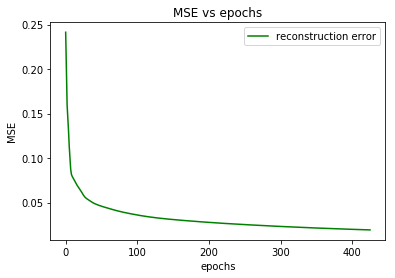

***********************************
number of epochs: 426
reconstruction error:  0.01928254346918599
***********************************
***********************************
bottle_neck_size :  49
***********************************
0 61.12105160071582


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:149: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


100 55.405622855348554
200 55.320137167201345
300 55.27016581922832
400 55.23525798631119
500 55.22108880983753
600 55.210612844371376
700 55.199229502684936
800 55.19188337448427
900 55.188161049933
Reached threshold


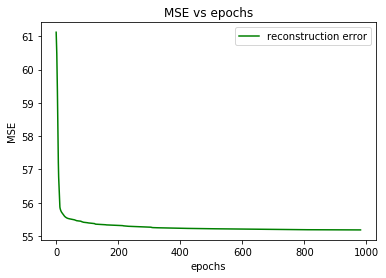

***********************************
number of epochs: 982
reconstruction error:  55.185861135399605
***********************************
***********************************
bottle_neck_size :  24
***********************************
0 850.7548289085482
100 828.8451255271336
200 828.75523448199
300 828.6965050610288
400 828.6578032868474
500 828.6461708954974
600 828.6372852172045
700 828.6214129269358
800 828.6125932122079
900 828.5117239363568


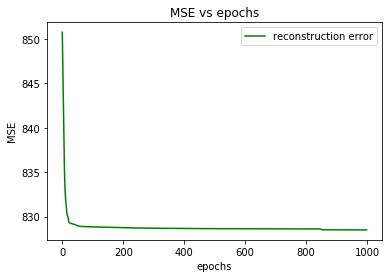

***********************************
number of epochs: 1000
reconstruction error:  828.504957466905
***********************************
***********************************
0 0.2085854750987714
50 0.11250108005378112
100 0.09973242587642771
Reached threshold
***********************************
number of epochs: 120
training reconstruction error:  0.09800151743581756
testing reconstruction error:  0.12924331997516225
***********************************


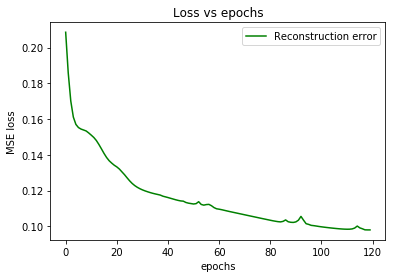

In [32]:
x_train_noisy = Flip_Bits(x_train,0.6)
x_test_noisy = Flip_Bits(x_test,0.6)
Denoiser, x_train_denoised, x_test_denoised = Stacked_Denoising_AE(x_train,x_train_noisy,x_test,x_test_noisy,bottle_neck_size = 100)

In [0]:
def ShowImage(x_test,x_test_noisy,x_test_denoised):
  print('Image: 1')
  plt.imshow(x_test[4660].reshape(28,28),cmap = 'gray')
  plt.xlabel('Actual')
  plt.show()
  plt.imshow(x_test_noisy[4660].reshape(28,28),cmap = 'gray')
  plt.xlabel('Noisy')
  plt.show()
  plt.imshow(x_test_denoised[4660].reshape(28,28),cmap = 'gray')
  plt.xlabel('Denoised')
  plt.show()
  print("============================================")
  print('Image: 2')
  plt.imshow(x_test[40].reshape(28,28),cmap = 'gray')
  plt.xlabel('Actual')
  plt.show()
  plt.imshow(x_test_noisy[40].reshape(28,28),cmap = 'gray')
  plt.xlabel('Noisy')
  plt.show()
  plt.imshow(x_test_denoised[40].reshape(28,28),cmap = 'gray')
  plt.xlabel('Denoised')
  plt.show()
  print("============================================")
  print('Image: 3')
  plt.imshow(x_test[60].reshape(28,28),cmap = 'gray')
  plt.xlabel('Actual')
  plt.show()
  plt.imshow(x_test_noisy[60].reshape(28,28),cmap = 'gray')
  plt.xlabel('Noisy')
  plt.show()
  plt.imshow(x_test_denoised[60].reshape(28,28),cmap = 'gray')
  plt.xlabel('Denoised')
  plt.show()

Image: 1


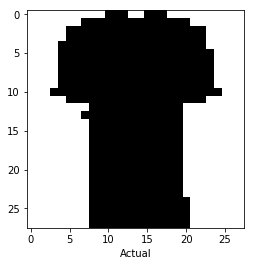

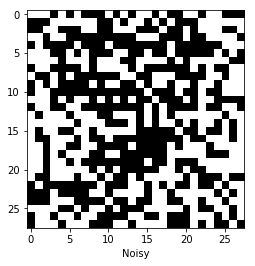

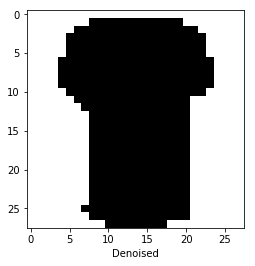

Image: 2


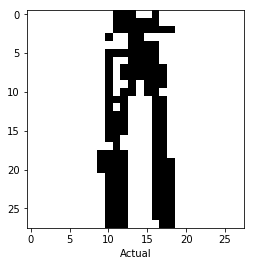

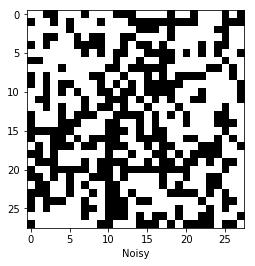

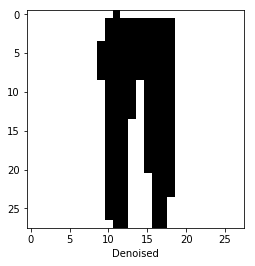

Image: 3


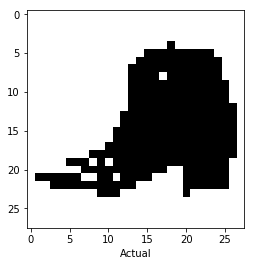

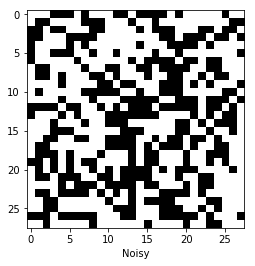

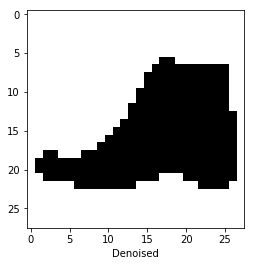

In [31]:
ShowImage(x_test,x_test_noisy,x_test_denoised)

0 0.24324413885711987
50 0.05507413114118078
100 0.047268213386648425
150 0.042855210088014246
200 0.03998248285329486
250 0.03794967240004214
300 0.03639970174232362
350 0.03510397766326
400 0.034023012705361164
Reached threshold
***********************************
number of epochs: 450
training reconstruction error:  0.033132401742422005
testing reconstruction error:  0.03740690748561549
***********************************


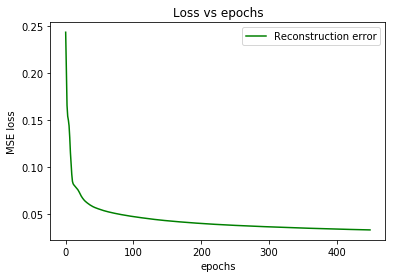

In [0]:
x_train_noisy_20_percenr = Flip_Bits(x_train,0.2)
x_test_noisy_20_percent = Flip_Bits(x_test,0.2)
_ , x_train_denoised_20, x_test_denoised_20 = DenoisingAE_Model(x_train, x_train_noisy_20_percenr,x_test, x_test_noisy_20_percent, bottle_neck_size = 100 ,nonlinear_layer_size = 500 )

Image: 1


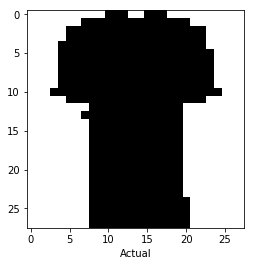

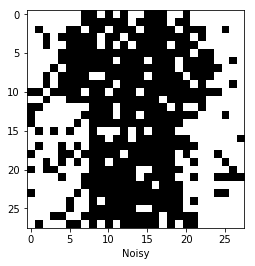

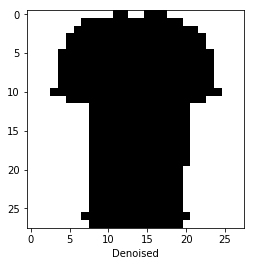

Image: 2


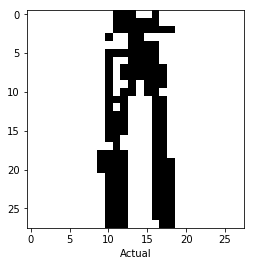

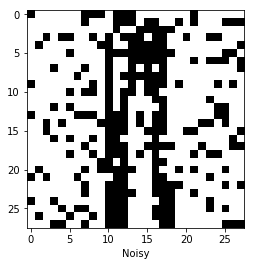

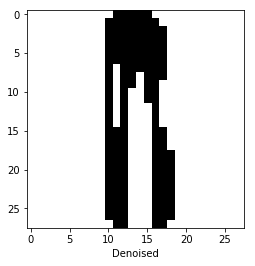

Image: 3


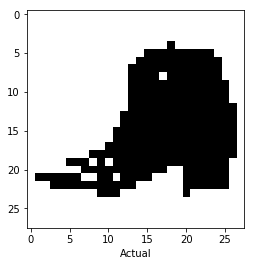

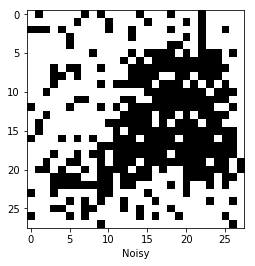

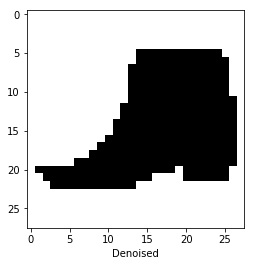

In [0]:
ShowImage(x_test,x_test_noisy_20_percent,x_test_denoised_20)

plt.imshow(x_test_denoised[4660].reshape(28,28))

0 0.2430823618786879
50 0.06184068424052036
100 0.053499674056063665
150 0.0490646748675534
200 0.04607892962973111
250 0.04398226034650155
300 0.04237191233558908
Reached threshold
***********************************
number of epochs: 309
training reconstruction error:  0.04222480751138439
testing reconstruction error:  0.04763531313654525
***********************************


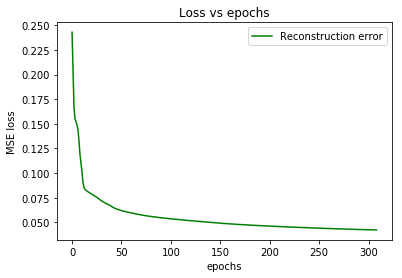

In [0]:
x_train_noisy_30_percenr = Flip_Bits(x_train,0.3)
x_test_noisy_30_percent = Flip_Bits(x_test,0.3)
_ , x_train_denoised_30, x_test_denoised_30 = DenoisingAE_Model(x_train, x_train_noisy_30_percenr,x_test, x_test_noisy_30_percent, bottle_neck_size = 100 ,nonlinear_layer_size = 500 )

Image: 1


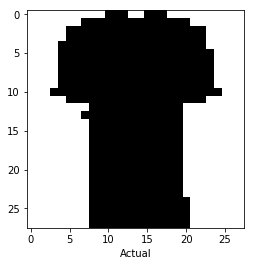

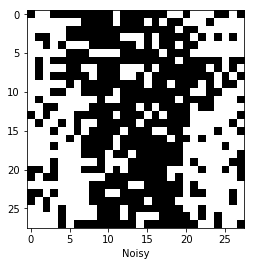

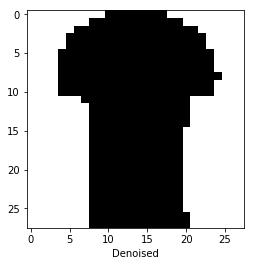

Image: 2


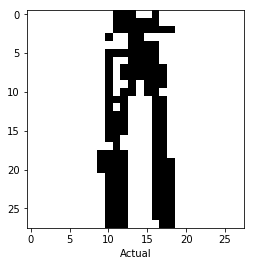

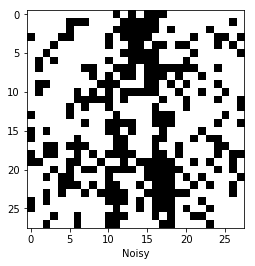

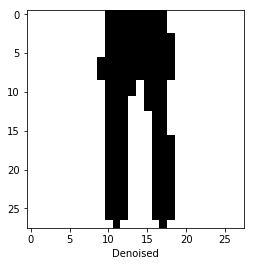

Image: 3


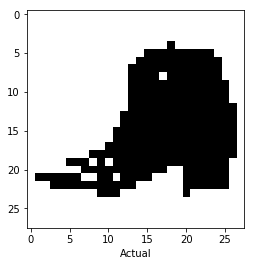

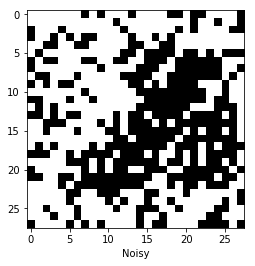

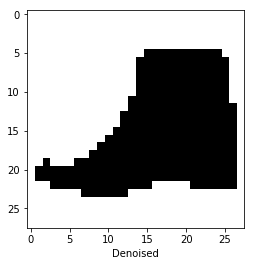

In [0]:
ShowImage(x_test,x_test_noisy_30_percent,x_test_denoised_30)

0 0.24308704934604258
50 0.06947041394890038
100 0.06103503911381068
150 0.05616096701733837
200 0.053520906392498645
Reached threshold
***********************************
number of epochs: 217
training reconstruction error:  0.05280236508369281
testing reconstruction error:  0.060402238490574675
***********************************


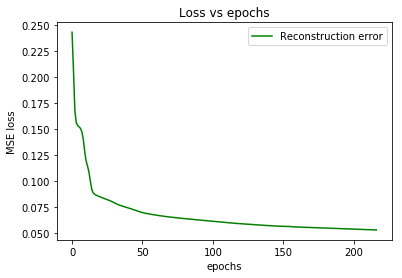

In [0]:
x_train_noisy_40_percenr = Flip_Bits(x_train,0.4)
x_test_noisy_40_percent = Flip_Bits(x_test,0.4)
_ , x_train_denoised_40, x_test_denoised_40 = DenoisingAE_Model(x_train, x_train_noisy_40_percenr,x_test, x_test_noisy_40_percent, bottle_neck_size = 100 ,nonlinear_layer_size = 500 )

Image: 1


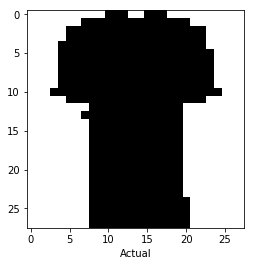

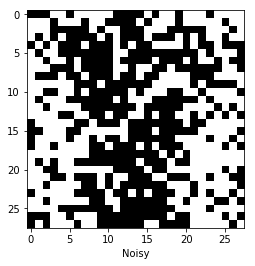

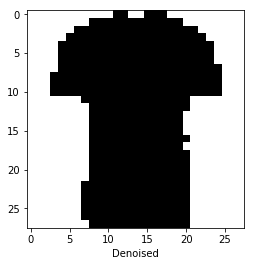

Image: 2


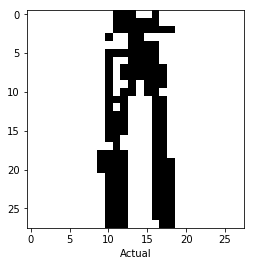

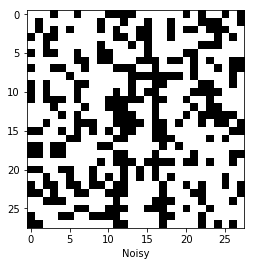

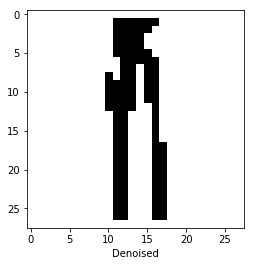

Image: 3


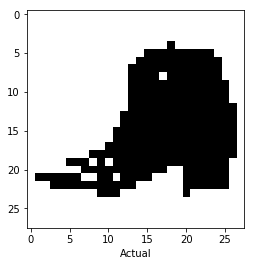

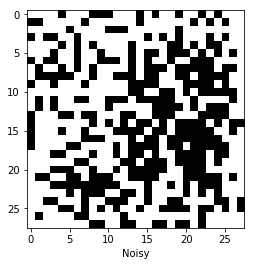

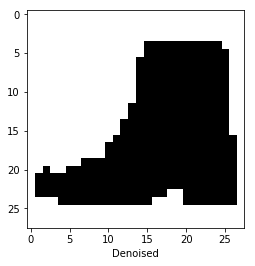

In [0]:
ShowImage(x_test,x_test_noisy_40_percent,x_test_denoised_40)

0 0.2441288677566428
50 0.08578910307139351
100 0.07258906969561443
Reached threshold
***********************************
number of epochs: 133
training reconstruction error:  0.06965835603120321
testing reconstruction error:  0.08099402839128339
***********************************


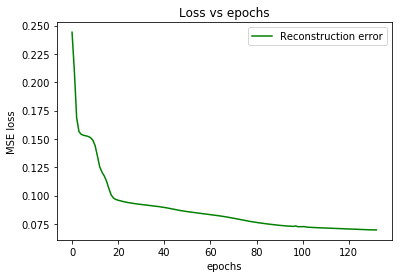

In [0]:
x_train_noisy_50_percenr = Flip_Bits(x_train,0.5)
x_test_noisy_50_percent = Flip_Bits(x_test,0.5)
_ , x_train_denoised_50, x_test_denoised_50 = DenoisingAE_Model(x_train, x_train_noisy_50_percenr,x_test, x_test_noisy_50_percent, bottle_neck_size = 100 ,nonlinear_layer_size = 500 )

Image: 1


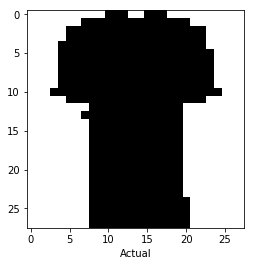

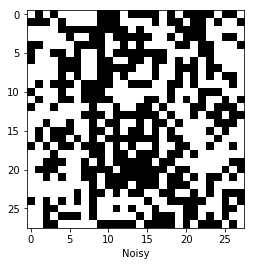

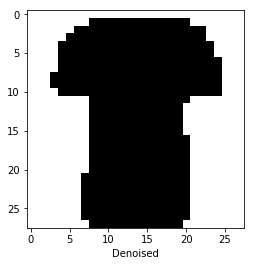

Image: 2


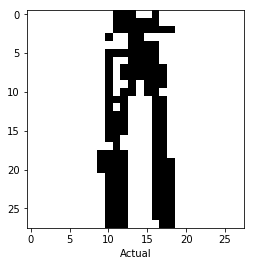

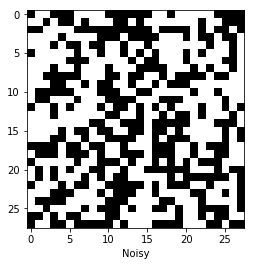

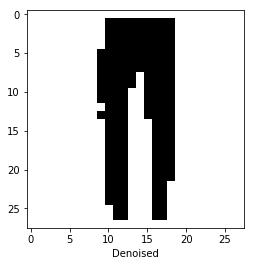

Image: 3


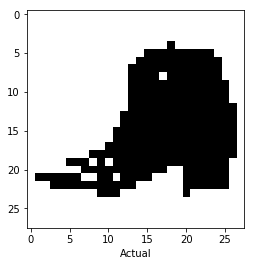

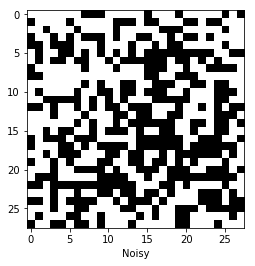

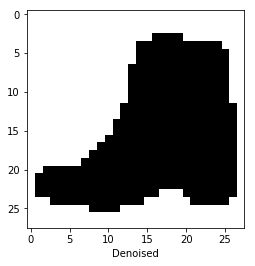

In [0]:
ShowImage(x_test,x_test_noisy_50_percent,x_test_denoised_50)

0 0.24497770316554468
50 0.11339514870675403
100 0.09144421701828857
150 0.08558078438249772
200 0.08183882061720352
Reached threshold
***********************************
number of epochs: 246
training reconstruction error:  0.07922802398109484
testing reconstruction error:  0.1363376336495071
***********************************


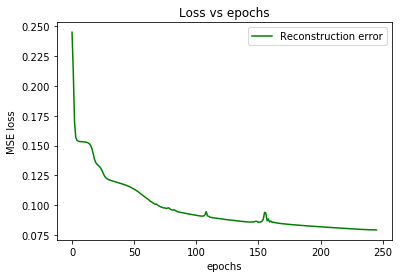

In [0]:
x_train_noisy_60_percenr = Flip_Bits(x_train,0.6)
x_test_noisy_60_percent = Flip_Bits(x_test,0.6)
_ , x_train_denoised_60, x_test_denoised_60 = DenoisingAE_Model(x_train, x_train_noisy_60_percenr,x_test, x_test_noisy_60_percent, bottle_neck_size = 100 ,nonlinear_layer_size = 500 )

Image: 1


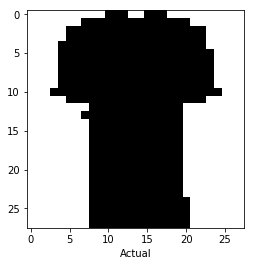

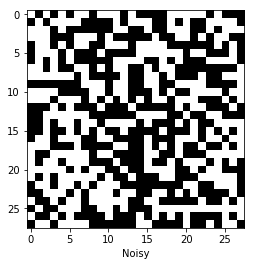

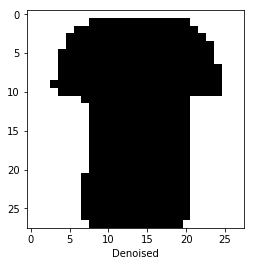

Image: 2


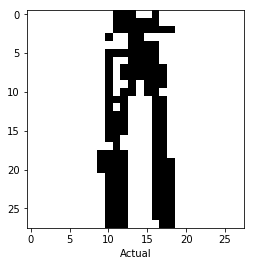

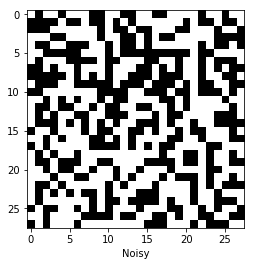

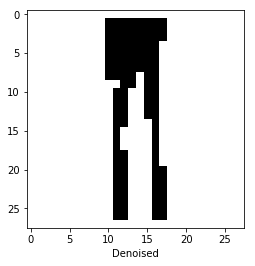

Image: 3


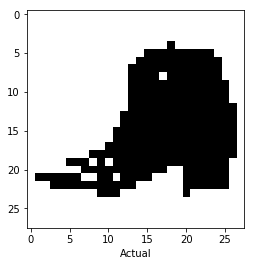

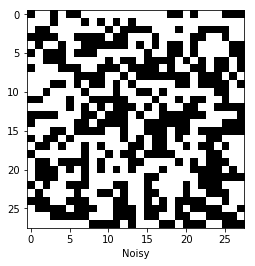

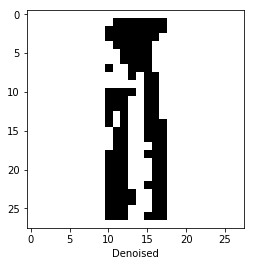

In [0]:
ShowImage(x_test,x_test_noisy_60_percent,x_test_denoised_60)